# Exemplo de deteção de contornos e Hough Circles

Este é um exemplo de deteção de contornos e de círculos em que os *defaults* falharam e foi preciso fazer vários ajustes.

Neste exemplo vamos tentar 2 abordagems:

* Melhorando os valores do `inRange` e fazendo o *fine tuning* das imagens subsequentes
* Introduzindo operadores morfológicos de dilatação e erosão

### Conteúdo

[Imagem de testes e cor do color picker](#img_inicial)

[Problemas com a filtragem simples](#problemas)

[Análise dos canais H, S e V](#analise_canais)

[Novos valores para o inRange](#novos_inrange)

[Blur para fechar pontos falhos](#blur)

[Deteção de contornos e centro de massa](#contornos)

[Centro de massa de um contorno](#centro_massa)

[Transformada de Hough Circles](#hough_circles)

[Limiarização para melhorar Hough Circles](#limiarizacao)

[Valor do acumulador dp de Hough Circles](#acumulador_dp)

[Alternativa com operadores morfológicos](#morfologia)

[Conclusão](#conclusao)



## Imports

In [3]:
import auxiliar as aux
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install imutils
import os

%matplotlib inline

Este script não deve ser executado diretamente


Versão da OpenCV

In [4]:
cv2.__version__

'3.4.1'

Diretório de trabalho:

In [5]:
print(os.getcwd())

C:\Users\willi\Downloads\Robotica_Wil\aula02


<div id="img_inicial">

## Imagem de testes

Vamos praticar alguns conceitos vistos na imagem abaixo

<img src=stars.png width=50%>

## Usando as cores vindas do color picker

Usando um *color picker* idêntico ao que consta no arquivo [aula2_OpenCV_Filtragem.ipynb](aula2_OpenCV_Filtragem.ipynb) obtivemos:

```python

    cor_rgb = "#fdb22b"
```    

In [6]:
cor_rgb = "#fdb22b"

In [7]:
cor1, cor2 = aux.ranges(cor_rgb)

In [8]:
cor1

array([ 9, 50, 50], dtype=uint8)

In [9]:
cor2

array([ 19, 255, 255], dtype=uint8)

Vamos ler a imagem, converter em HSV e ver como ficou a filtragem

In [10]:
img_bgr = cv2.imread("stars.png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

<div id="problemas">
    

## Problemas com a filtragem simples

In [11]:
mascara = cv2.inRange(img_hsv, cor1, cor2)

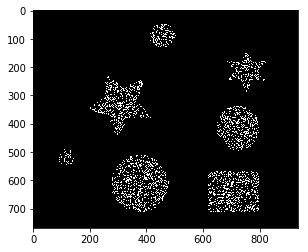

In [12]:
plt.imshow(mascara, cmap="Greys_r", vmin=0, vmax=255)

A imagem acima nos mostra que a filtragem **não ficou muito boa**. Isso é um sinal de que precisamos tentar melhorar o resultado do `inRange`. Ou seja, precisamos mexer nos valores HSV das variáveis `cor1` e `cor2` que vieram do `aux.ranges` .

Podemos tentar usar tentativa e erro, ou podemos tentar fazer um *histograma* para entender onde nossa máscara não ficou boa.

Na aula 1 vimos como fazer um histograma. As funções abaixo foram baseadas no exemplo de histograma dado naquela aula

<div id="analise_canais">

## Análise dos canais

Vamos usar seguidamente as funções a seguir para mostrar os canais H, S e V separadamente e também as imagens com cada canal em isolamento.

Estas funções são baseadas no material da aula 1.

In [13]:
def hsv_hists(img, plt):
    """
        Plota o histograma de cada um dos canais HSV
        img - imagem HSV
        plt - objeto matplotlib
    """
    plt.figure(figsize=(20,10)); 
    img_h = img[:,:,0]
    img_s = img[:,:,1]
    img_v = img[:,:,2]
    histo_plot(img_h, "r","H", plt);
    histo_plot(img_s, "g","S", plt);
    histo_plot(img_v, "b","V", plt);

def make_hist(img_255, c, label, plt):
    """ img_255 - uma imagem com 3 canais de 0 até 255
        c a cor do plot
        label - o label do gráfico
        plt - matplotlib.pyplot
    """
    hist,bins = np.histogram(img_255.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    # plt.plot(cdf_normalized, color = c)
    plt.hist(img_255.flatten(),256,[0,256], color = c)
    plt.xlim([0,256])
    plt.legend(label, loc = 'upper left')
    plt.plot()

def histo_plot(img, cor, label, plt):
    """
        img - imagem
        cor - cor
        plt - matplotlib.pyplot object

    """
    plt.figure(figsize=(10,5))
    make_hist(img, cor, label, plt)
    plt.show()
    plt.figure(figsize=(10,5))
    plt.imshow(img, cmap="Greys_r")#, vmin=0, vmax=255)    
    plt.title(label)


Vamos agora usar as funções acima para fazer um histograma e ver a imagem em cada um dos canais

<Figure size 1440x720 with 0 Axes>

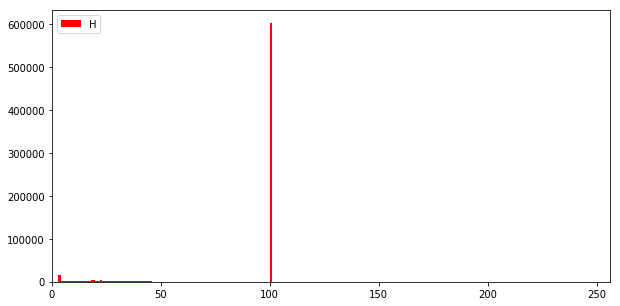

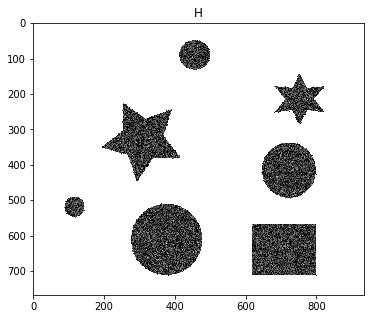

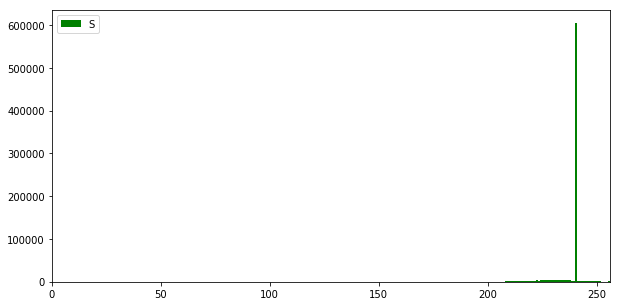

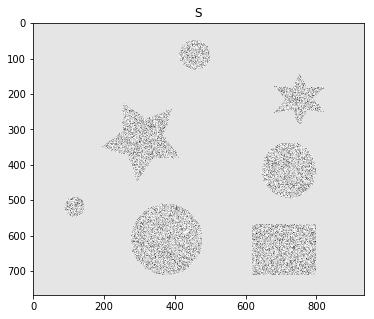

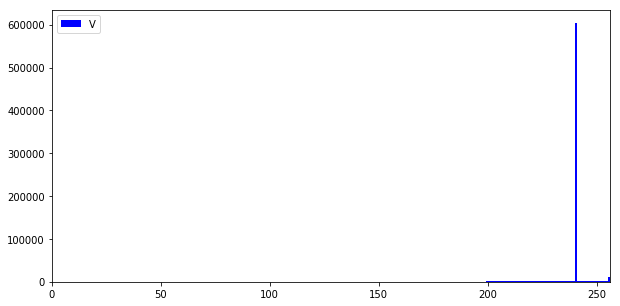

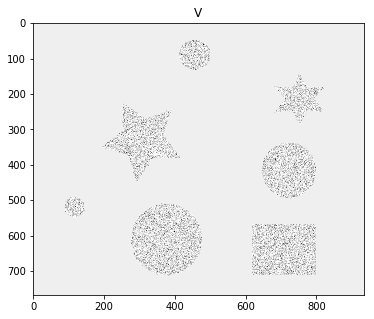

In [14]:
hsv_hists(img_hsv, plt)

<div id="novos_inrange">

## Novos valores para o inRange

Agora é importante analisar de forma **crítica** os valores gerados pelo comando `aux.ranges` levando em conta o histograma apresentado anteriormente. Relembrando os valores vindos do *color picker*:

In [15]:
cor1

array([ 9, 50, 50], dtype=uint8)

In [16]:
cor2

array([ 19, 255, 255], dtype=uint8)

Notemos que a componente *H* gerada pelo `aux.ranges` está contida na faixa $[9,19]$, entretanto uma análise desta componente nos histogramas acima mostra:

* uma grande concentração acima do $50$
* a imagem do fundo azulado aparece mais clara no canal *H*, indicando que os pixels verdes são esta grande concentração acima do 50
* uma concentração bem menor espalhada aproximadamente na faixa $[0,40]$
* A imagem do canal *H* mostra que os pixels das figuras são mais escuros neste canal. Provavelmente são as figuras que estão entre $0$ e $40$

A conclusão a que chegamos é que precisamos de uma faixa *H* para o `inRange` um pouco mais abrangente. Vamos tentar com os valores abaixo.

**Observe como se declaram arrays do numpy com o tipo adequado**

Basta incluir a especificação do pacote `np` antes de `np.array` e `np.uint8`.

In [17]:
cor1_v2 = np.array([ 0, 50, 50], dtype=np.uint8)
cor2_v2 = np.array([ 45, 255, 255], dtype=np.uint8)

Vamos agora aplicar as novas faixas para obter uma nova máscara

In [18]:
mascara_2 = cv2.inRange(img_hsv, cor1_v2, cor2_v2)

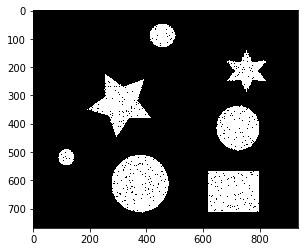

In [19]:
plt.imshow(mascara_2, cmap="Greys_r", vmin=0, vmax=255);

**Sucesso!** Note que a filtragem ficou bem melhor agora

Ainda assim há pequenos furinhos na imagem. Podemos tentar eliminá-los com um pouco de *blur* ou [operações morfológicas](#morfologia)

## Blur para fechar pontos falhos

Vamos aplicar o *blur*:

In [20]:
mascara_blur = cv2.blur(mascara_2, (3,3))

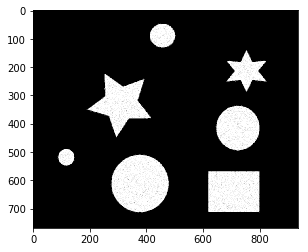

In [21]:
plt.imshow(mascara_blur, cmap="Greys_r", vmin=0, vmax=255);

Podemos notar que fomos bem-sucedidos. O *blur* ajudou a fechar os furos.

Podemos passar agora à deteção de contornos e círculos

In [22]:
mask = mascara_blur

<div id="contornos">

## Deteção de contornos e cálculo do centro de massa

Vamos aplicar uma deteção de contornos igual ao exemplo da aula 2

In [23]:
contornos, arvore = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ValueError: too many values to unpack (expected 2)

Precisamos criar uma cópia da máscara para fins de desenho:

In [ ]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) 
contornos_img = mask_rgb.copy() # Cópia da máscara para ser desenhada "por cima"


Vamos verificar os contornos detectados

In [ ]:
cv2.drawContours(contornos_img, contornos, -1, [255, 0, 0], 5);

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(contornos_img);

<div id="centro_massa">

### Centro de massa de um contorno

Muitas vezes é útil sabermos qual é o *centro de massa* de um contorno. Para esta finalidade vamos definir a função a seguir:

In [ ]:
def center_of_contour(contorno):
    """ Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
    M = cv2.moments(contorno)
    # Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (int(cX), int(cY))
    
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)
    
font = cv2.FONT_HERSHEY_SIMPLEX

def texto(img, a, p):
    """Escreve na img RGB dada a string a na posição definida pela tupla p"""
    cv2.putText(img, str(a), p, font,1,(0,50,100),2,cv2.LINE_AA)
    
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

Vamos percorrer a lista de contornos e aplicar as funções de centro de massa definidas acima

In [ ]:
for c in contornos:
    a = cv2.contourArea(c) # área
    p = center_of_contour(c) # centro de massa
    crosshair(contornos_img, p, 20, (128,128,0))
    texto(contornos_img, np.round(a,2),p)
    



Vamos verificar e desenhar o centro dos contornos e a área de cada círculo próxima de si.

In [ ]:
plt.figure(figsize=(14,10))

plt.imshow(contornos_img);

<div id="hough_circles">

## Transformada de Hough Circles

Vamos tentar aplicar a transformada de Hough Circles avaliando os valores mais adequados para a distância entre círculos detectados e quais são seus tamanhos mínimos e máximos.

In [ ]:
bordas = auto_canny(mask)
circles=cv2.HoughCircles(image=bordas,method=cv2.HOUGH_GRADIENT,dp=1.5,minDist=40,param1=200,param2=100,minRadius=5,maxRadius=200)
bordas_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2RGB)
output = bordas_rgb

if circles is not None:        
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

In [ ]:

plt.imshow(output, cmap="Greys_r", vmin=0, vmax=255)

Podemos notar que o resultado acima **ficou ruim**. Há muitos falsos positivos que foram detectados nas bordas internas do contorno.

Isso se deve ao fato de a máscara, usada, mesmo após o *blur*, ter pixels mais escuros em seu interior. 

Vamos recordar:

In [ ]:
plt.imshow(mask_rgb)

<div id="limiarizacao">

### Limiarização para melhorar Hough Circles

Vamos aplicar uma *limiarização* - valores abaixo *grayscale* de $100$ serão convertidos para zero e valores maiores serão transformados em branco.

In [ ]:
retorno, mask_limiar = cv2.threshold(mask, 100 ,255, cv2.THRESH_BINARY)

Observemos o resultado da limiarização. Notamos que ficou uma imagem binária que define bem as formas.

In [ ]:
plt.imshow(mask_limiar, cmap="Greys_r", vmin=0, vmax=255)

## HoughCircles novamente

Agora que temos a imagem acima, vamos tentar novamente aplicar a transformada de Hough para círculos.

In [ ]:

bordas = auto_canny(mask_limiar)
circles=cv2.HoughCircles(image=bordas,method=cv2.HOUGH_GRADIENT,dp=1.5,minDist=40,param1=50,param2=100,minRadius=5,maxRadius=200)
mask_limiar_rgb = cv2.cvtColor(mask_limiar, cv2.COLOR_GRAY2RGB)
bordas_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2RGB)

output =  bordas_rgb

if circles is not None:        
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

In [ ]:
plt.imshow(output)

<div id="acumulador_dp">

### Valor do acumulador dp de Hough Circles

Notemos que na imagem acima os círculos ainda não foram detectados.

Uma hipótese para este fenômeno é que as bordas estão muito tênues e portanto o algoritmo não as pegou. 

Vamos tentar alterar os parâmetros da função `cv2.HoughCircles`. 

O parâmetro *dp* diz respeito à relação entre o tamanho da imagem e o tamanho do acumulador.

Para obter o resultado abaixo testamos um acumulador entre $2$ e $4$ e o valor de $2.5$ deu bons resultados.

In [24]:
bordas = auto_canny(mask_limiar)
circles=cv2.HoughCircles(image=bordas,method=cv2.HOUGH_GRADIENT,dp=2.5,minDist=40,param1=50,param2=100,minRadius=5,maxRadius=150)
mask_limiar_rgb = cv2.cvtColor(mask_limiar, cv2.COLOR_GRAY2RGB)
bordas_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2RGB)

output =  bordas_rgb

if circles is not None:        
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

NameError: name 'auto_canny' is not defined

In [25]:
plt.figure(figsize=(12,9))
plt.imshow(output)

NameError: name 'output' is not defined

<Figure size 864x648 with 0 Axes>

Note que uma vez encontrados os círculos, podemos usar as informações de onde ficam seus centros e raios para realizar as operações de que necessitamos.

<div id="morfologia">

## Alternativa com operadores morfológicos

Vamos substituir as três etapas: melhoria da máscara, eliminação de ruído feita com blur e alteração da resolução para o Hough Circles funcionar por operações morfológicas.

Recordemos como a imagem aparecia logo após o `inRange` inicial


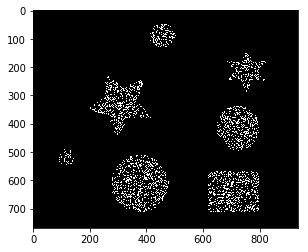

In [26]:
plt.imshow(mascara, cmap="Greys_r", vmin=0, vmax=255)

### Limpeza via operações morfológicas

Vamos usar as operações morfológica de *abertura*.  Esta operação preenche todos os buracos menores que um dado `kernel`e depois corrói suas bordas com outro `kernel`. 

In [27]:
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
cruz = ((0,1,0),(1,1,1),(0,1,0))
kernel_erode = np.array(cruz,np.uint8)



Vamos ver como ficam os *kernels* de dilatação e erosão, que são uma elipse e uma cruz, respectivamente

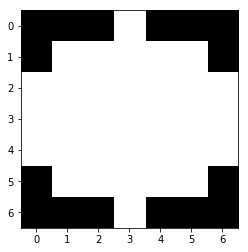

In [28]:
plt.imshow(kernel_dilate, cmap = "Greys_r")

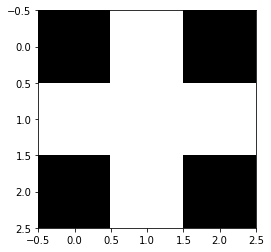

In [29]:
plt.imshow(kernel_erode, cmap="Greys_r")

In [30]:
morphology_dilate = cv2.dilate(mascara, kernel_dilate)#, iterations=2)

In [31]:
morphology_erode = cv2.erode(morphology_dilate, kernel_erode)

Na Figura a seguir vemos na parte **esquerda** o resultado da dilatação e na **direita** o resultado da erosão.

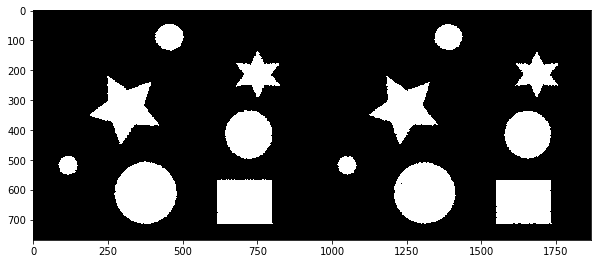

In [32]:
plt.figure(figsize=(10,7))
plt.imshow(np.hstack((morphology_dilate, morphology_erode)), cmap="Greys_r")

Para fins de testes, vamos fazer uma deteção de hough circles sobre o resultado. Note que também foi preciso mexer um pouco no valor *dp* do acumulador (usamos $2.5$ em vez de $2.0$)

In [33]:
morphology_erode_rgb = cv2.cvtColor(morphology_erode, cv2.COLOR_GRAY2RGB)

In [34]:
bordas_morph = auto_canny(morphology_erode)
bordas_morph_rgb = cv2.cvtColor(bordas_morph, cv2.COLOR_GRAY2RGB)
output = bordas_morph_rgb

circles=cv2.HoughCircles(bordas_morph,cv2.HOUGH_GRADIENT,2.5,40,param1=50,param2=100,minRadius=3,maxRadius=130)

if circles is not None:        
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        # cv2.circle(img, center, radius, color[, thickness[, lineType[, shift]]])
        cv2.circle(output,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(output,(i[0],i[1]),2,(0,0,255),3)

NameError: name 'auto_canny' is not defined

In [ ]:
plt.imshow(output)

Você deve ter notado que um dos círculos mais à esquerda não foi detectado. Poderíamos tentar reforçar a imagem das bordas usando um kernel de convolução para realce de bordas (veja aula 2), ou ainda usar mais uma operação morfológica de dilatação.

# Conclusão

Neste Jupyter Notebook vimos duas alternativas de abordagem de *troubleshooting* para filtragem baseada em cores de pixel. 

Vimos também o cálculo de centro de massa de contorno e ajuste de alguns parâmetros do Hough Circles.